In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop
from keras_preprocessing import image as kimage

tf.__version__

'2.14.0'

In [14]:
# Load the pre-made horses or humans dataset, choosing to split the data between humans and horses (in multi-classification you could split between any number below or equal to the amount within the dataset), and using `with_info` to supply metadata for the dataset to `dataset_info`. Finally, asserting what `our_train_dataset` is a tensorflow dataset ensures that the dataset has been loaded correctly.
tf.random.set_seed(8)

(our_train_dataset, our_test_dataset), dataset_info = (tfds.load
                                                       ('horses_or_humans', split = ['train', 'test'], data_dir = 'content/', shuffle_files = True, with_info = True))

assert isinstance(our_train_dataset, tf.data.Dataset)

In [15]:
# We can use the metadata we saved from `with_info` to tell us more about the dataset:
image_shape = dataset_info.features["image"].shape

print(f'Shape of Images in the Dataset: \t{image_shape}')
print(f'Number of Classes in the Dataset: \t{dataset_info.features["label"].num_classes}')

names_of_classes = dataset_info.features["label"].names

for name in names_of_classes:
    print(f'Label for class "{name}": \t\t{dataset_info.features["label"].str2int(name)}')

Shape of Images in the Dataset: 	(300, 300, 3)
Number of Classes in the Dataset: 	2
Label for class "horses": 		0
Label for class "humans": 		1


In [16]:
print(f'Total examples in Train Dataset: \t{len(our_train_dataset)}')
pos_tr_samples = sum(i['label'] for i in our_train_dataset)

print(f'Horses in Train Dataset: \t\t{len(our_train_dataset) - pos_tr_samples}')
print(f'Humans in Train Dataset: \t\t{pos_tr_samples}')

print(f'\nTotal examples in Test Dataset: \t{len(our_test_dataset)}')

pos_ts_samples = sum(i['label'] for i in our_test_dataset)
print(f'Horses in Test Dataset: \t\t{len(our_test_dataset) - pos_ts_samples}')
print(f'Humans in Test Dataset: \t\t{pos_ts_samples}')

Total examples in Train Dataset: 	1027
Horses in Train Dataset: 		500
Humans in Train Dataset: 		527

Total examples in Test Dataset: 	256
Horses in Test Dataset: 		128
Humans in Test Dataset: 		128


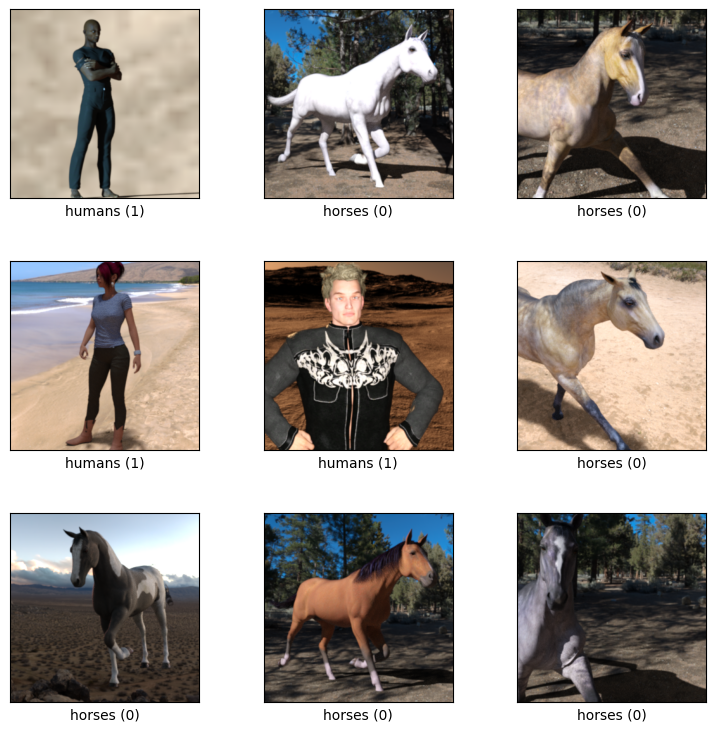

In [17]:
# Display a sample of the dataset
fig = tfds.show_examples(our_train_dataset, dataset_info)

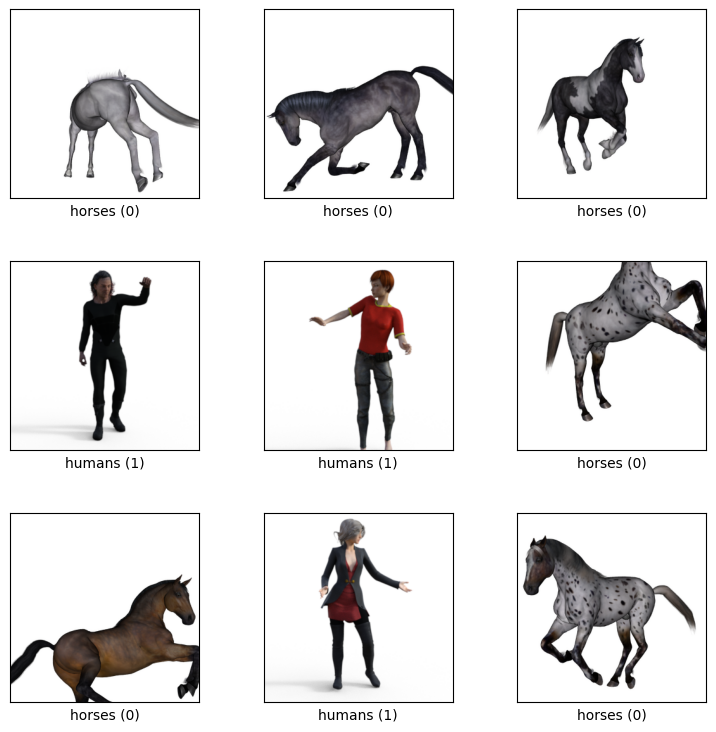

In [18]:
fig_test = tfds.show_examples(our_test_dataset, dataset_info)

The dark mode of PyCharm may be causing these samples to display in negative

In [19]:
# Building a CNN using a list of layers, rather than separately defining and then explicitly adding layers to the model
our_cnn_model = models.Sequential([

    layers.Conv2D(filters = 16, kernel_size = (3,3), input_shape = image_shape),
    layers.Activation('relu'),
    
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3)),
    layers.Activation('relu'),
    
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Flatten(),
    
    layers.Dense(units = 512),
    layers.Activation('relu'),
    
    layers.Dense(units = 1),
    layers.Activation('sigmoid')

])

# compile using RMSprop for optimiser, and binary cross entropy as there are only 2 classes to differentiate between
our_cnn_model.compile(optimizer=RMSprop(learning_rate=0.001), 
                      loss='binary_crossentropy', metrics=['acc'], 
                      loss_weights=None, weighted_metrics=None, 
                      run_eagerly=None, steps_per_execution=None)

print(our_cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 298, 298, 16)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                 

In [20]:
# Sets colour values from 0-255 0-1 when used
normalization_layer = layers.Rescaling(1./255)

# Apply the colour value normalisation to the dataset
our_train_dataset = our_train_dataset.map(lambda x: (normalization_layer(x['image']), x['label']), num_parallel_calls = tf.data.experimental.AUTOTUNE)

our_train_dataset = our_train_dataset.cache()
# Ensure dataset is randomly ordered
our_train_dataset = our_train_dataset.shuffle(len(our_train_dataset))
# Load a batche of 128 images/labels
our_train_dataset = our_train_dataset.batch(128)

our_train_dataset = our_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Apply the same normalisation and load 32 more images/labels for testing
our_test_dataset = our_test_dataset.map(lambda x: (normalization_layer(x['image']), x['label']), num_parallel_calls = tf.data.experimental.AUTOTUNE)

our_test_dataset = our_test_dataset.cache()
our_test_dataset = our_test_dataset.batch(32)
our_test_dataset = our_test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# Train the model on the 128 examples we collected and normalised for our training dataset, and validate with the 32 testing items
history = our_cnn_model.fit(our_train_dataset, validation_data = our_test_dataset, epochs=15, validation_steps=8, verbose=1)

Epoch 1/15
9/9 [==============================] - 62s 7s/step - loss: 14.6307 - acc: 0.4800 - val_loss: 2.0117 - val_acc: 0.5000
Epoch 2/15
9/9 [==============================] - 35s 4s/step - loss: 0.7164 - acc: 0.5725 - val_loss: 4.9075 - val_acc: 0.5000
Epoch 3/15
9/9 [==============================] - 35s 4s/step - loss: 1.0019 - acc: 0.7283 - val_loss: 0.4829 - val_acc: 0.8633
Epoch 4/15
9/9 [==============================] - 36s 4s/step - loss: 0.4035 - acc: 0.8228 - val_loss: 2.3758 - val_acc: 0.5000
Epoch 5/15
9/9 [==============================] - 35s 4s/step - loss: 0.4326 - acc: 0.8023 - val_loss: 1.6756 - val_acc: 0.5117
Epoch 6/15
9/9 [==============================] - 36s 4s/step - loss: 0.2559 - acc: 0.9046 - val_loss: 1.8184 - val_acc: 0.5234
Epoch 7/15
9/9 [==============================] - 34s 4s/step - loss: 0.2242 - acc: 0.9104 - val_loss: 0.5890 - val_acc: 0.7656
Epoch 8/15
9/9 [==============================] - 35s 4s/step - loss: 0.1450 - acc: 0.9513 - val_loss: 

1/1 [==============================] - 0s 301ms/step
[[0.5629547]]
Image is a human


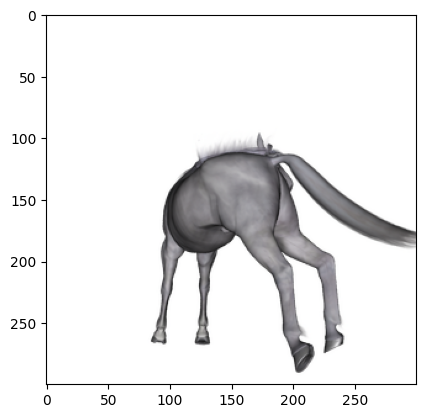

In [22]:
from matplotlib.pyplot import imshow

# Get a single item from the testing dataset
for images, labels in our_test_dataset.take(1):
    # Display the item
    imshow(np.asarray(images[0]))
    image_to_test = kimage.img_to_array(images[0])
    image_to_test = np.array([image_to_test])
    # Make a prediction of whether the image is of a human or horse
    prediction = our_cnn_model.predict(image_to_test)
    
    # Print the prediction from the network, and a message interpretirn it
    print(prediction)
    if prediction > 0.5:
        print("Image is a human")
    else:
        print("Image is a horse")

1/1 [==============================] - 9s 9s/step


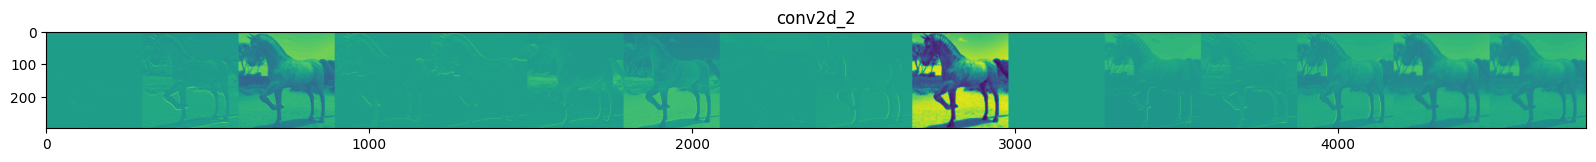

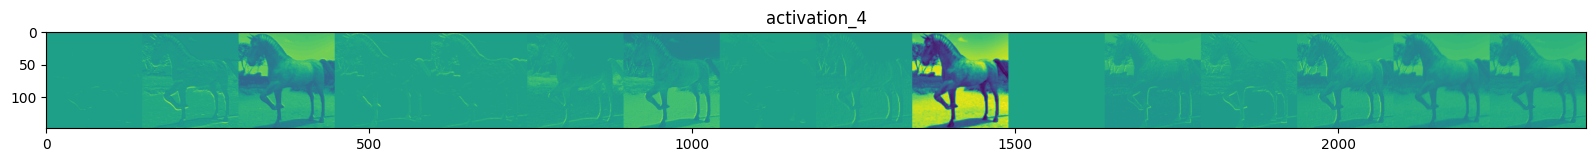

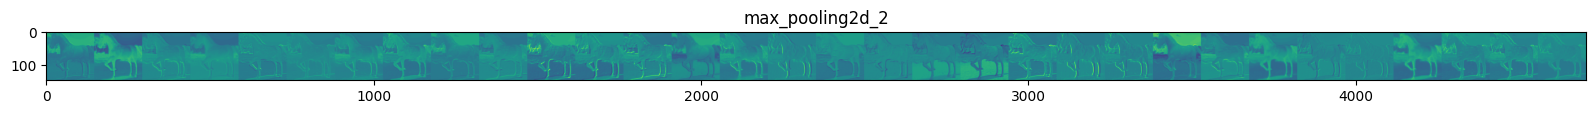

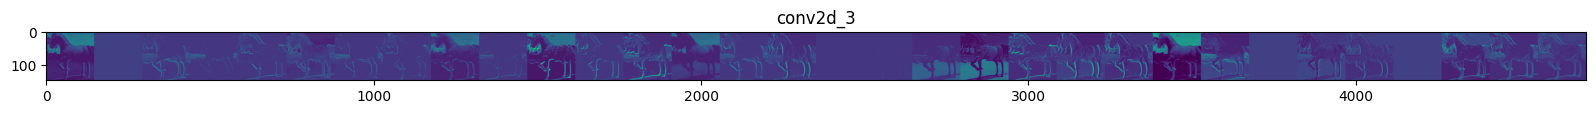

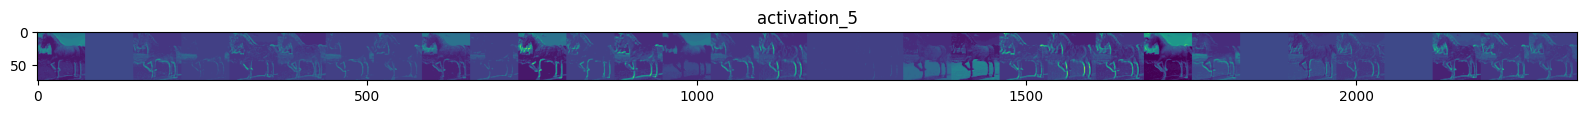

In [24]:
layer_outputs = []
# Collect outputs from the 2nd CNN layer onwards into `layer_outputs`
for layer in our_cnn_model.layers[1:]:
    layer_outputs.append(layer.output)

layer_names = []
# Collect the names of the CNN layers into `layer_names`
for layer in our_cnn_model.layers:
    layer_names.append(layer.name)

features_model = models.Model(inputs = our_cnn_model.input, outputs = layer_outputs)
# Get the next sample and make a prediction of what the image is
random_sample = our_train_dataset.take(1)
layer_predictions = features_model.predict(random_sample)

# Get the predictions from each layer and plot them
for layer_name, prediction in zip(layer_names, layer_predictions):
    if len(prediction.shape) != 4:
        continue

    num_features = prediction.shape[-1]
    size = prediction.shape[1]
    grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        img = prediction[0, :, :, i]
        # Ensure no division by 0 (not handled in book)
        img = ((((img - img.mean()) / max(1, img.std())) * 64) + 128)
        img = np.clip(img, 0, 255).astype('uint8')
        grid[:, i * size : (i + 1) * size] = img

    scale = 20. / num_features

    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.imshow(grid)